# install

## I

In [ ]:
# Install (versions compatibles + évite le package `keras` standalone)
%pip install -U pip setuptools wheel
%pip install -U tabulate scikit-learn pandas numpy matplotlib seaborn gensim "tensorflow==2.16.1"

# Test TensorFlow (ne fait pas planter le notebook si l'environnement Windows manque de DLL)
try:
	import tensorflow as tf
	print("TensorFlow:", tf.__version__)
	print(tf.reduce_sum(tf.random.normal([1000, 1000])))
except Exception as e:
	print("TensorFlow n'a pas pu se charger (runtime natif / DLL).")
	print("Erreur:", repr(e))
	print("\nPistes courantes (Windows):")
	print(" - Installer/mettre à jour 'Microsoft Visual C++ Redistributable 2015-2022 (x64)'")
	print(" - Éviter Python du Microsoft Store: utiliser python.org/conda + nouveau venv")
	print(" - CPU trop ancien (AVX requis): utiliser un autre environnement (WSL/conda) ou une build no-AVX")

## Si echec - diagnostic

In [ ]:
# Diagnostic TensorFlow (sortie courte, utile sous Windows)
import sys, platform, site, pathlib, traceback

print("Python:", sys.version.replace("\n", " "))
print("Executable:", sys.executable)
print("Platform:", platform.platform())
print("Machine:", platform.machine())

site_paths = []
try:
    site_paths = site.getsitepackages()
except Exception:
    site_paths = [site.getusersitepackages()]
print("Site-packages:")
for p in site_paths:
    print(" -", p)

# Cherche des traces d'une install cassée (ex: dossier '~ensorflow' -> warning pip)
for p in site_paths:
    base = pathlib.Path(p)
    if base.exists():
        bad = sorted([x.name for x in base.glob("~ensorflow*")])
        if bad:
            print("\nTraces suspectes dans", str(base))
            for name in bad:
                print(" -", name)

print("\nTest import tensorflow...")
try:
    # Évite un vieux module resté en mémoire après uninstall/reinstall
    for k in list(sys.modules.keys()):
        if k == "tensorflow" or k.startswith("tensorflow.") or k.startswith("keras") or k.startswith("tensorboard"):
            sys.modules.pop(k, None)

    import tensorflow as tf
    print("tensorflow module:", tf)
    print(" - __file__:", getattr(tf, "__file__", None))
    spec = getattr(tf, "__spec__", None)
    if spec is not None:
        print(" - spec.origin:", spec.origin)
        print(" - spec.submodule_search_locations:", list(spec.submodule_search_locations or []))
    print("OK TensorFlow:", tf.__version__)
except Exception as e:
    print("ECHEC import TensorFlow:", repr(e))
    print("\nTraceback (résumé):")
    print(traceback.format_exc())

## Si echec - cleanup

In [ ]:
# Cleanup TensorFlow/Keras (corrige les résidus type `~ensorflow` + réinitialise l'install)
# À exécuter si l'import TF est cassé / warnings pip `Ignoring invalid distribution ~ensorflow`
import sys, site, pathlib, shutil

print("Python executable:", sys.executable)
if "WindowsApps" in sys.executable:
    print("⚠️ Python Microsoft Store détecté : c'est une source fréquente de soucis avec TF. ")
    print("   Recommandé: Python depuis python.org/Miniconda + venv, puis re-sélectionner le kernel.")

# 1) Désinstall propre via pip (dans le kernel courant)
%pip uninstall -y tensorflow tensorflow-intel tensorflow-cpu keras keras-nightly tensorboard tensorboard-data-server tensorflow-estimator

# 2) Suppression des résidus dans le site-packages UTILISATEUR (pas dans WindowsApps)
user_sp = pathlib.Path(site.getusersitepackages())
print("User site-packages:", user_sp)

patterns = [
    "~ensorflow*", "tensorflow", "tensorflow-*dist-info", "tensorflow_*dist-info",
    "~keras*", "keras", "keras-*dist-info",
    "tensorboard", "tensorboard-*dist-info", "tensorboard_data_server*",
    "tensorflow_estimator*", "tensorflow_io_gcs_filesystem*"
 ]

removed = []
if user_sp.exists():
    for pat in patterns:
        for path in user_sp.glob(pat):
            try:
                if path.is_dir():
                    shutil.rmtree(path, ignore_errors=True)
                else:
                    path.unlink(missing_ok=True)
                removed.append(str(path))
            except Exception as e:
                print("Impossible de supprimer", path, "->", repr(e))
else:
    print("User site-packages introuvable (", user_sp, ")")

print("\nSupprimé (résumé):")
if removed:
    for p in removed[:50]:
        print(" -", p)
    if len(removed) > 50:
        print(f" ... +{len(removed)-50} autres")
else:
    print("(rien à supprimer, ou déjà propre)")

print("\nEnsuite:")
print("1) Redémarre le kernel")
print("2) Relance la cellule Install (TensorFlow==2.16.1)")
print("3) Relance la cellule Diagnostic")

# PHASE I

https://gite.lirmm.fr/poncelet/deeplearning/-/raw/main/La%20vision%20par%20apprentissage%20profond/1%20-%20Classification%20d'images%20avec%20des%20CNN/Notebook_ClassificationImagesAvecCNN.pdf?ref_type=heads

https://gite.lirmm.fr/poncelet/deeplearning/-/blob/main/La%20vision%20par%20apprentissage%20profond/1%20-%20Classification%20d'images%20avec%20des%20CNN/LaClassificationImagesAvecCNN.ipynb?ref_type=heads

On bosse sur fashion MNIST
Le réseau baseline est un CNN
Je dois comprendre:
- Ce qu'est un CNN
- Qu'est ce qu'une couche de convolution (c'est quoi la différence avec une autre couche)
- Expliquer ce qu'est une classification
- analyser un modèle :
  - dimension
  - loss
  - accuracy
  - architecture
  - filtres
  - savoir lire les courbes
- comprendre l'entrainement
- les optimizers
- les fonctions d'évaluation
- les activations
- le pooling

# Notebook

## Classification d'image avec les CNN

### imports

In [122]:
# Suppression des avertissements liés à Scikit-learn
import warnings  # Masquer les avertissements (ex. : FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Librairies générales
import pandas as pd  # Librairie pour la manipulation de données
import numpy as np  # Librairie pour le calcul numérique
import sys  # Fonctions et variables liées à l'interpréteur Python
import copy  # Création de copies d'objets
from numpy import mean, std  # Fonctions de calcul de moyenne et d'écart type
import zipfile  # Traitement de fichiers zip
import os  # Manipulation de fichiers et chemins

# Librairie affichage
import matplotlib.pyplot as plt  # Outils de visualisation 2D
from matplotlib import pyplot  # Interface de la bibliothèque Matplotlib
import seaborn as sns  # Bibliothèque de visualisation de données basée sur Matplotlib

# Scikit-learn pour l'évaluation des modèles
from sklearn.metrics import confusion_matrix  # Matrice de confusion
from sklearn.model_selection import KFold  # Outils de validation croisée
from sklearn.metrics import accuracy_score  # Calcul de l'accuracy
from sklearn.model_selection import train_test_split  # Découpage train/test

# TensorFlow et Keras
import tensorflow as tf  # Librairie de deep learning
import keras  # API haut niveau pour construire et entraîner des modèles de deep learning
from keras import layers  # Modules de couches pour construire des modèles Keras
from keras import models  # Outils pour créer des modèles Keras
from keras import optimizers  # Outils d'optimisation
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Générateur d'images pour l'augmentation des données
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping  # Rappels pour le suivi et l'arrêt précoce
from keras.layers import Input, Dense, Dropout, Flatten, Lambda  # Types de couches Keras
from keras.layers import Conv2D, MaxPooling2D  # Couches convolutionnelles et de pooling
from keras.preprocessing import image  # Outils de prétraitement d'images
from tensorflow.keras.models import Model, load_model  # Définition / chargement de modèles
from keras.datasets import fashion_mnist  # Jeu de données Fashion MNIST
from tensorflow.keras.utils import to_categorical  # Conversion en encodage one-hot
from tensorflow.keras.optimizers import SGD  # Optimiseur Stochastic Gradient Descent
from tensorflow.keras.applications.resnet50 import ResNet50  # Modèle ResNet50 pré-entraîné
from tensorflow.keras.preprocessing import image  # Prétraitement d'images pour les modèles Keras

In [3]:
def plot_curves(histories):
    """
    Fonction pour afficher les courbes de loss et d'accuracy
    moyennées et écart-types à travers les k-folds.

    Paramètres :
    - histories (list) : Historique d'entraînement des différents plis K-folds.
    """

    # Initialisation des figures
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Extraction du nombre d'époques d'après l'un des historiques
    epochs = range(len(histories[0].history['loss']))

    # Calcul des moyennes et des écart-types pour chaque époque
    mean_loss = np.mean([history.history['loss'] for history in histories],
                        axis=0)
    std_loss = np.std([history.history['loss'] for history in histories],
                      axis=0)

    mean_val_loss = np.mean([history.history['val_loss'] for history in histories],
                            axis=0)
    std_val_loss = np.std([history.history['val_loss'] for history in histories],
                          axis=0)

    mean_accuracy = np.mean([history.history['accuracy'] for history in histories],
                            axis=0)
    std_accuracy = np.std([history.history['accuracy'] for history in histories],
                          axis=0)

    mean_val_accuracy = np.mean([history.history['val_accuracy'] for history in histories],
                                axis=0)
    std_val_accuracy = np.std([history.history['val_accuracy'] for history in histories],
                              axis=0)

    # Couleurs pour les courbes
    train_color = 'blue'
    val_color = 'orange'

    # Courbes de loss avec moyenne et écart-type
    ax1.plot(epochs, mean_loss, color=train_color, label='Train')
    ax1.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss,
                     color=train_color, alpha=0.2)

    ax1.plot(epochs, mean_val_loss, color=val_color, label='Validation')
    ax1.fill_between(epochs, mean_val_loss - std_val_loss,
                     mean_val_loss + std_val_loss, color=val_color, alpha=0.2)

    # Courbes d'accuracy avec moyenne et écart-type
    ax2.plot(epochs, mean_accuracy, color=train_color, label='Train')
    ax2.fill_between(epochs, mean_accuracy - std_accuracy,
                     mean_accuracy + std_accuracy, color=train_color, alpha=0.2)

    ax2.plot(epochs, mean_val_accuracy, color=val_color, label='Validation')
    ax2.fill_between(epochs, mean_val_accuracy - std_val_accuracy,
                     mean_val_accuracy + std_val_accuracy,
                     color=val_color, alpha=0.2)

    # Titres, labels et légendes
    ax1.set_title(f'Loss (k={len(histories)})')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.set_title(f'Accuracy (k={len(histories)})')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

In [5]:
# Définition du répertoire cible
model_dir = "./cnn_models/"

# Création du répertoire s'il n'existe pas
os.makedirs(model_dir, exist_ok=True)

zip_file = "cnn_models.zip"

#!wget https://www.lirmm.fr/~poncelet/Ressources/cnn_models.zip
!Powershell.exe -Command ((new-object System.Net.WebClient).DownloadFile('https://www.lirmm.fr/~poncelet/Ressources/cnn_models.zip','cnn_models.zip'))

# Extraction du fichier ZIP
with zipfile.ZipFile(zip_file, "r") as zip_ref:
        zip_ref.extractall(model_dir)

# Suppression du fichier ZIP après extraction pour économiser de l'espace
os.remove(zip_file)

In [6]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [7]:
print("Nombre d'exemples du jeu d'apprentissage : ", X_train.shape[0])
print("Nombre d'exemples du jeu de test : ", X_test.shape[0])
print ("Format du jeu d'apprentissage : ", X_train.shape)
print ("Format du jeu de test : ", X_test.shape)
print ("Format d'une image", X_train[0].shape)

Nombre d'exemples du jeu d'apprentissage :  60000
Nombre d'exemples du jeu de test :  10000
Format du jeu d'apprentissage :  (60000, 28, 28)
Format du jeu de test :  (10000, 28, 28)
Format d'une image (28, 28)


In [56]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Petite cellule pour afficher plusieurs éléments

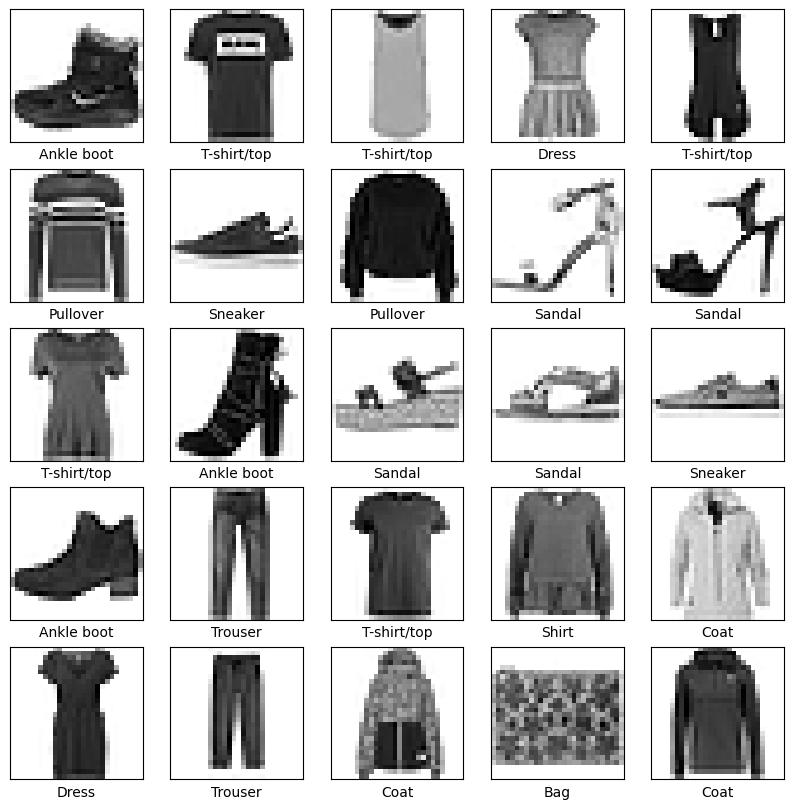

In [9]:
#Visualisation d'images
plt.figure(figsize=(10,10))
columns = 25
for i in range(columns):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i],cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])

ça, c'est une de nos données, et son Domaine

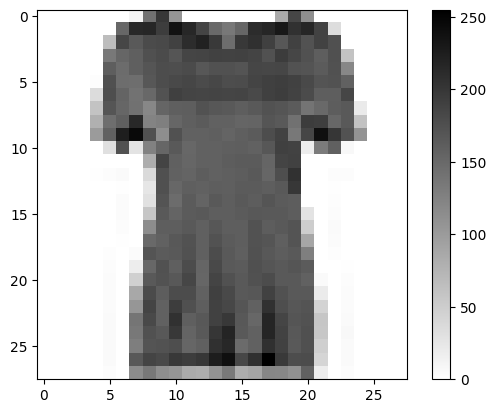

In [10]:
numimage=10
plt.figure()
plt.imshow(X_train[numimage], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Important, on normalise, pour facilité l'entrainement (pas besoin de fonction customs, entre 0 et 1 c'est standart, et en plus ça permettra de lier le tout avec des lois de stat/proba)

In [13]:
# Sauvegarde des données avant transformation
X_train_original=copy.deepcopy(X_train)
X_test_original=copy.deepcopy(X_test)

train_images = X_train / 255.0
test_images = X_test / 255.0

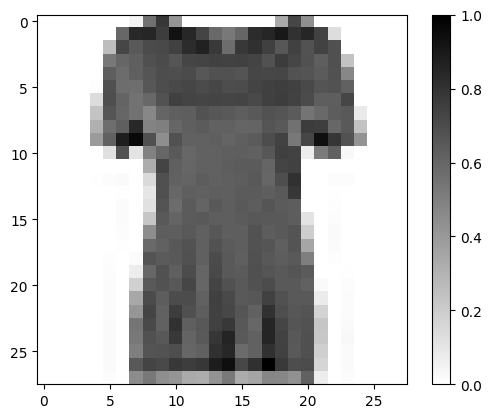

In [12]:
numimage=10
plt.figure()
plt.imshow(train_images[numimage], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

## des convolutions à la classification

La convolution, c'est l'application d'un filtre sur chaque partie de l'image. Le filtre (ou noyau) c'est une matrice, qui est plus petite que l'image. Les coéfficiants de cette matrices, on peut les trouver grâce à l'entrainement. Cette étape est permet de "digerer" l'image

In [8]:
def load_dataset():
    """
    Charge et prépare le jeu de données Fashion MNIST pour l'entraînement

    Étapes :
    - Chargement des ensembles d'entraînement et de test.
    - Reshape pour ajouter un canal (passage de 28x28 à 28x28x1).
    - Encodage des étiquettes en one-hot.

    Retourne :
    - X_train : données d'entraînement reshaped (échantillons, 28, 28, 1).
    - y_train : étiquettes d'entraînement encodées en one-hot.
    - X_test : données de test reshaped (échantillons, 28, 28, 1).
    - y_test : étiquettes de test encodées en one-hot.
    """
    # Chargement des données Fashion MNIST
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

    # Redimensionnement des images pour inclure un canal unique (28x28x1)
    X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
    X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

    # Encodage one-hot des étiquettes de classe
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    return X_train, y_train, X_test, y_test

def clean_data(train, test):
    """
    Prétraitement des données : conversion en float, normalisation entre 0 et 1.

    Paramètres :
    - train : tableau de données d'entraînement
    - test : tableau de données de test

    Retourne :
    - train_norm : données d'entraînement normalisées
    - test_norm : données de test normalisées
    """
    # Conversion des entiers en floats pour permettre la normalisation
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')

    # Normalisation des valeurs entre 0 et 1
    train_norm /= 255.0
    test_norm /= 255.0

    return train_norm, test_norm

Archi du modèle :
- Input
- Convolution(relu) avec pooling -> en gros, ça applique le masque, et reduit la dimension spatiale en gardant les infos(pooling)
- Flatten -> formate pour Dense
- Dense(relu)
- Dense(softmax) -> classification ici

Les blocs de convolutions extraient les features map tout seul, ce qui rend le travail de classification bien plus simple pour la couche dense !!!

### Modèle baseline

In [15]:
def define_model(shapeinput=(28, 28, 1)):
    # Couche d'entrée
    inputs = Input(shape=shapeinput, name="Input_Layer")

    # Couche convolutionnelle avec pooling
    x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
               name="Conv2D_1")(inputs)
    x = MaxPooling2D(pool_size=(2, 2), name="MaxPooling2D_1")(x)

    # Flatten pour préparer les données pour la partie dense
    x = Flatten(name="Flatten")(x)

    # Couches denses pour la classification
    x = Dense(100, activation='relu', name="Dense_1")(x)
    outputs = Dense(10, activation='softmax', name="Output")(x)

    model = Model(inputs=inputs, outputs=outputs, name="Baseline_CNN")

    # Compilation du modèle
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

K-Fold?

Je crois que l'on coupe les ensembles de validations en plusieurs, et que l'on mesure les perfs de façon indépendante

In [16]:
def evaluate_model(model, dataX, dataY, folds=5, epochs=10):
    """
    Évalue le modèle avec une validation croisée K-fold.

    Paramètres :
    - model : modèle de réseau de neurones Keras à évaluer.
    - dataX : données d'entrée pour l'entraînement et la validation.
    - dataY : étiquettes de sortie correspondantes.
    - folds : nombre de splits pour la validation croisée.
    - epochs : nombre d'époques pour l'entraînement de chaque split.

    Retourne :
    - scores : liste des scores d'accuracy du modèle pour chaque split.
    - histories : liste des historique d'entraînement pour chaque split.
    """
    scores, histories = [], []  # Initialisation des scores et historiques
    kfold = KFold(n_splits=folds, shuffle=True, random_state=1)

    # Itération sur chaque split généré par le K-fold
    for train_ix, test_ix in kfold.split(dataX):
        # Sélection des données d'entraînement et de test pour le fold
        X_train, y_train = dataX[train_ix], dataY[train_ix]
        X_test, y_test = dataX[test_ix], dataY[test_ix]

        # Réinitialisation du modèle avant chaque itération
        model = define_model()

        # Entraînement du modèle
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=32,
                            validation_data=(X_test, y_test), verbose=1)

        # Évaluation du modèle sur les données de test actuelles
        loss, acc = model.evaluate(X_test, y_test, verbose=0)
        print(f'Précision : {acc * 100:.3f}%')

        # Stockage de l'historique
        scores.append(acc)
        histories.append(history)

    return scores, histories

Pour tout executer

In [17]:
def run_evaluation(folds, epochs):
    """
    Fonction d'évaluation

    Cette fonction effectue les étapes suivantes :
    1. Chargement du jeu de données Fashion MNIST.
    2. Prétraitement des données : nettoyage et normalisation.
    3. Initialisation du modèle de base et affichage de sa structure.
    4. Évaluation du modèle avec validation croisée (K-fold).
    5. Affichage des courbes de performance et des statistiques de précision.

    Paramètres :
    - folds (int) : Nombre de splits pour la validation croisée (K-fold).
    - epochs (int) : Nombre d'époques d'entraînement pour chaque pli du K-fold.

    Retourne :
    - None
    """

    # Chargement du jeu de données d'entraînement et de test
    X_train, y_train, X_test, y_test = load_dataset()

    # Prétraitement des données : nettoyage et normalisation
    X_train, X_test = clean_data(X_train, X_test)

    # Initialisation du modèle de base
    model = define_model()
    print(model.summary())

    # Évaluation du modèle
    scores, histories = evaluate_model(model, X_train, y_train, folds, epochs)

    # Affichage des courbes de performance
    plot_curves(histories)

    # Affichage des statistiques de précision : moyenne et écart-type
    print(f'Précision : moyenne={mean(scores) * 100:.3f}% écart-type={std(scores) * 100:.3f}%, k={len(scores)}')

Model: "Baseline_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_1 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2D_1 (MaxPooling2D)   │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 100)            │       540,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 542,230 (2.07 MB)

 Trainable params: 542,230 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7876 - loss: 0.5885 - val_accuracy: 0.8413 - val_loss: 0.4365
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8675 - loss: 0.3710 - val_accuracy: 0.8824 - val_loss: 0.3288
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8851 - loss: 0.3142 - val_accuracy: 0.8911 - val_loss: 0.2978
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8981 - loss: 0.2788 - val_accuracy: 0.8884 - val_loss: 0.3098
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9083 - loss: 0.2521 - val_accuracy: 0.8785 - val_loss: 0.3210
Précision : 87.853%
Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7826 - loss: 0.5943 - val_accuracy: 0.8563 - val_loss: 0.4124
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8674 - loss: 0.3690 - val_accuracy: 0.8756 - val_loss: 0.3488
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8859 - loss: 0.3165 -

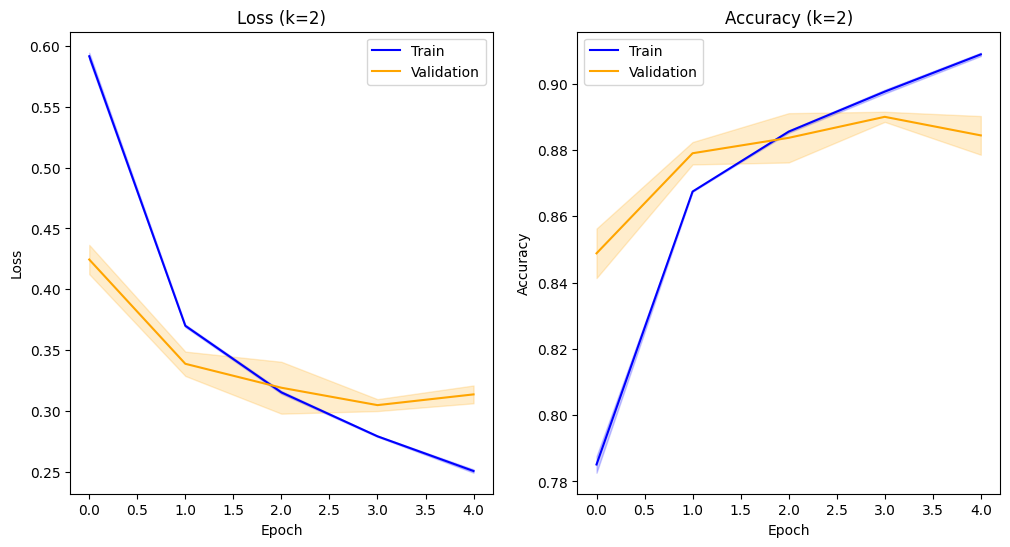

Précision : moyenne=88.437% écart-type=0.583%, k=2


In [18]:
k=2 # Nombre de folds
epochs=5 # Nombre d'epochs
shapeinput=(28, 28, 1) # Format de l'image 28x28 sur 1 canal
run_evaluation(k,epochs)

Model: "Baseline_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_1 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2D_1 (MaxPooling2D)   │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 100)            │       540,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 542,230 (2.07 MB)

 Trainable params: 542,230 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8181 - loss: 0.5086 - val_accuracy: 0.8650 - val_loss: 0.3759
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8798 - loss: 0.3346 - val_accuracy: 0.8855 - val_loss: 0.3109
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8974 - loss: 0.2827 - val_accuracy: 0.8886 - val_loss: 0.3206
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9067 - loss: 0.2522 - val_accuracy: 0.9007 - val_loss: 0.2676
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9179 - loss: 0.2255 - val_accuracy: 0.9062 - val_loss: 0.2575
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9236 - loss: 0.2059 - val_accuracy: 0.9044 - val_loss: 0.2652
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9309 - loss: 0.1867 - val_accuracy: 0.9073 - val_loss: 0.2613
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9352 - loss: 0.17

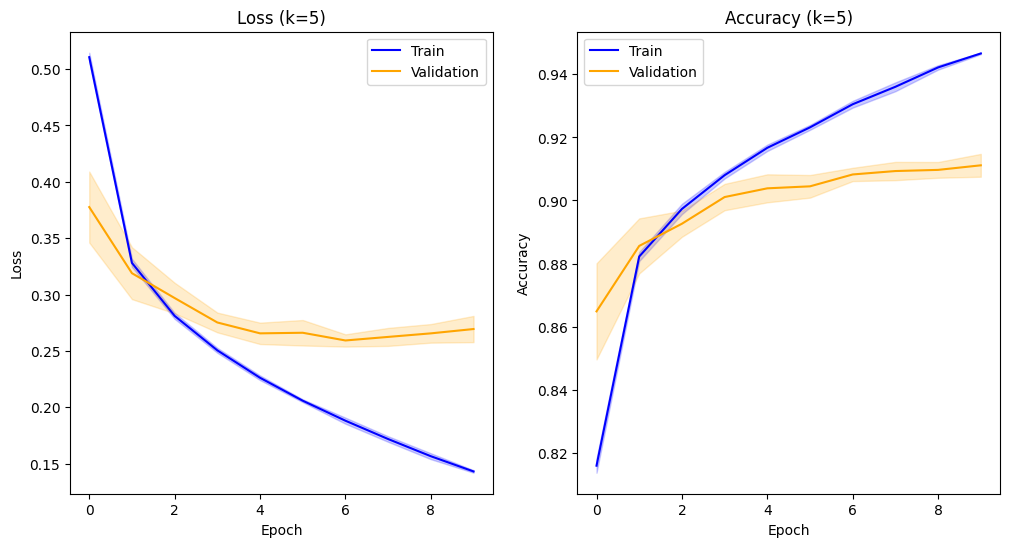

Précision : moyenne=91.115% écart-type=0.362%, k=5


In [19]:
k=5 # Nombre de folds
epochs=10 # Nombre d'epochs
shapeinput=(28, 28, 1) # Format de l'image 28x28 sur 1 canal
run_evaluation(k,epochs)

### Analyse du modèle

In [20]:
model = define_model()
print(model.summary())

Model: "Baseline_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_1 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2D_1 (MaxPooling2D)   │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 100)            │       540,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 542,230 (2.07 MB)

 Trainable params: 542,230 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

None


- Conv2D_1:
    - 28x28x1 -> 26x26x32
    - 32 filtres
    - filtres 3x3
    - Sans padding
    - Stride de 1
    - 9 params filtre + 1 biais par filtres
- Max Pooling:
    - 26x26x32 -> 13x13x32
    - Pas de paramètres
    - applique une reduction de dimensions
- Flatten:
    - 13x13x32 -> 5408
    - pas de params, ça pack tout dans un vecteur de dimension 1
- Dense_1:
    - 5408 -> 100
    - 100 neurones
    - 100 * (5408 poids et 1 biais)
    - 540900 paramètres !
- Output:
    - 100 -> 10
    - (1 + 1) * 10 paramètres


Puisque la courbe evaluation descent plus mais que la courbe loss continue, on a du sur-apprentissage.
Comme solutions:
- Augmenter les données.
- Ajouter un dropout (on désactive aléatoirement un pourcentage de neuronnes, pour pas qu'il ai assez de place pour mémoriser les données de training)
- Pénaliser les poids trop élevé
- réduire le learning rate (pour pas "sauter" le minimum local)
- ajuster les tailles de batch (plus petit -> plus de calcul de gradients)

Pour augmenter l'accuracy d'un modèle on peut:
- utiliser un padding (pour garder les bords)
- augmenter la profondeur du réseau (plus de convolutions mais attention au sur apprentissage!)
- Fine-tuning (adapter un réseau à une tâche spécifique)

Pour enrichir:
```py

tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,                # Centrer les données en soustrayant la moyenne
    samplewise_center=False,                 # Centrer chaque échantillon
    featurewise_std_normalization=False,     # Normaliser les données en divisant par l'écart-type
    samplewise_std_normalization=False,      # Normaliser chaque échantillon
    zca_whitening=False,                     # Appliquer le blanchiment ZCA
    zca_epsilon=1e-06,                      # Epsilon pour le blanchiment ZCA
    rotation_range=0,                        # Plage de degrés pour les rotations aléatoires
    width_shift_range=0.0,                  # Fraction de la largeur totale pour les décalages horizontaux aléatoires
    height_shift_range=0.0,                 # Fraction de la hauteur totale pour les décalages verticaux aléatoires
    brightness_range=None,                   # Plage pour les ajustements aléatoires de luminosité
    shear_range=0.0,                         # Angle de cisaillement dans le sens antihoraire
    zoom_range=0.0,                          # Plage pour le zoom aléatoire
    channel_shift_range=0.0,                 # Décalage des canaux de couleur
    fill_mode='nearest',                     # Les points en dehors des limites sont remplis selon le mode choisi
    cval=0.0,                                # Valeur utilisée pour les points en dehors des limites lorsque fill_mode est 'constant'
    horizontal_flip=False,                   # Retourner aléatoirement les entrées horizontalement
    vertical_flip=False,                     # Retourner aléatoirement les entrées verticalement
    rescale=None,                            # Facteur de mise à l'échelle
    preprocessing_function=None,             # Fonction qui sera appliquée à chaque image
    data_format=None,                        # Format des données d'image, soit 'channels_last' soit 'channels_first'
    validation_split=0.0,                   # Fraction des données réservée pour la validation
    dtype=None                               # Type de données
)


```

In [21]:
X_train, y_train, X_test, y_test = load_dataset()
# nettoyage et normalisation des données
X_train, X_test = clean_data(X_train, X_test)

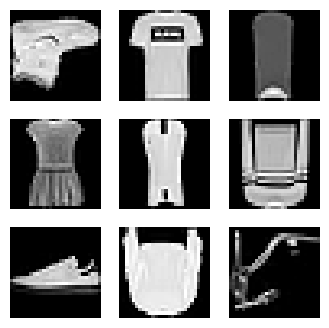

In [22]:
# ImageDataGenerator avec flip horizontal et vertical
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

for X_batch, y_batch in datagen.flow(X_train, y_train,
                                     batch_size=9, shuffle=False):
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4, 4))

    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(X_batch[i * 3 + j].reshape(28, 28),
                            cmap=plt.get_cmap("gray"))
            ax[i][j].axis('off')

    plt.show()
    break

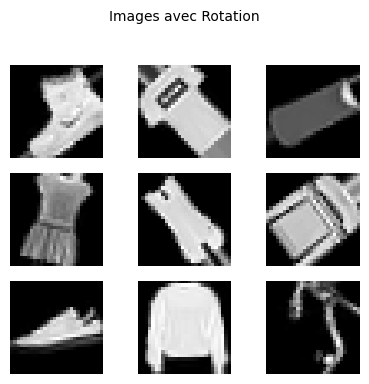

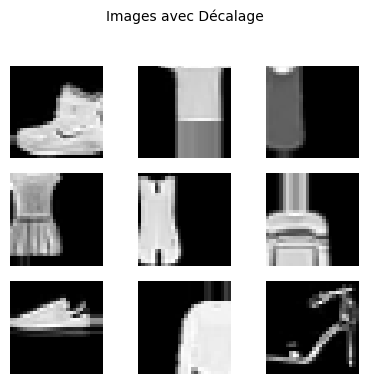

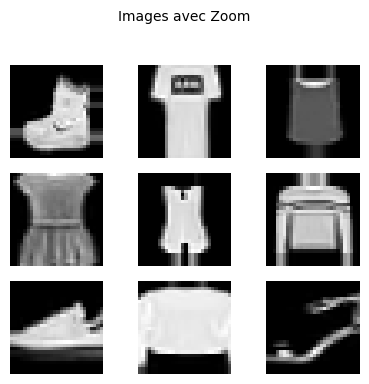

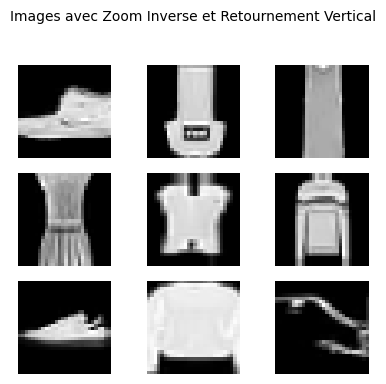

In [23]:
def plot_augmented_images(X_train, y_train, augmentation_params,
                          title, batch_size=9):
    """
    Fonction pour afficher des images augmentées avec les paramètres spécifiés.

    Paramètres :
    - X_train (array) : Ensemble d'images d'entraînement.
    - y_train (array) : Étiquettes des images d'entraînement.
    - augmentation_params (dict) : Paramètres d'augmentation .
    - title (str) : Titre du subplot pour la série d'images.
    - batch_size (int) : Taille du batch à afficher.
    """

    # ImageDataGenerator avec les paramètres fournis
    datagen = ImageDataGenerator(**augmentation_params)

    # Récupération d'un batch d'images augmentées
    for X_batch, y_batch in datagen.flow(X_train, y_train,
                                         batch_size=batch_size, shuffle=False):
        fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4, 4))
        fig.suptitle(title, fontsize=10)

        for i in range(3):
            for j in range(3):
                ax[i][j].imshow(X_batch[i * 3 + j].reshape(28, 28),
                                cmap=plt.get_cmap("gray"))
                ax[i][j].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        break


# Rotation
plot_augmented_images(X_train, y_train, {'rotation_range': 80},
                      title='Images avec Rotation')

# Décalage
shift = 0.4
plot_augmented_images(X_train,
                      y_train,
                      {'width_shift_range': shift, 'height_shift_range': shift},
                      title='Images avec Décalage')

# Zoom
zoom_range = 0.4
plot_augmented_images(X_train, y_train, {'zoom_range': zoom_range},
                      title='Images avec Zoom')

# Zoom inverse et retournement vertical
plot_augmented_images(X_train,
                      y_train, {'zoom_range': 0.4, 'vertical_flip': True},
                      title='Images avec Zoom Inverse et Retournement Vertical')

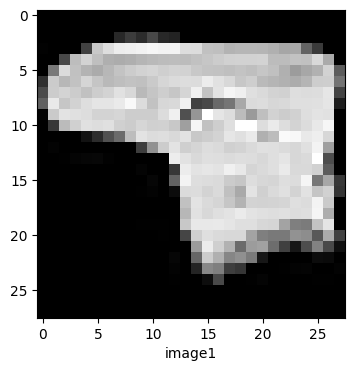

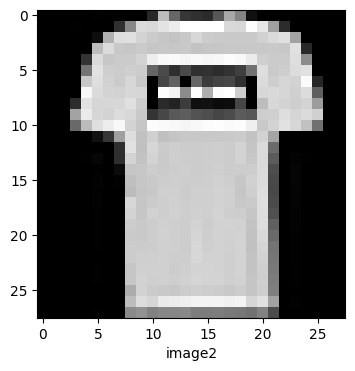

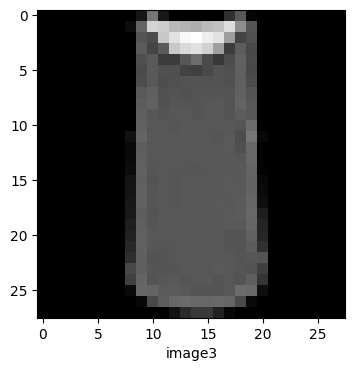

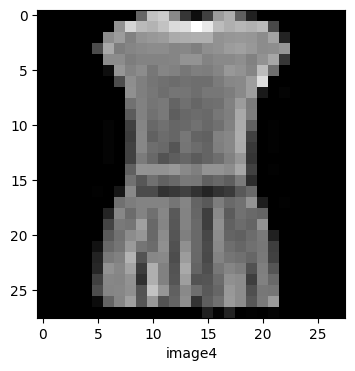

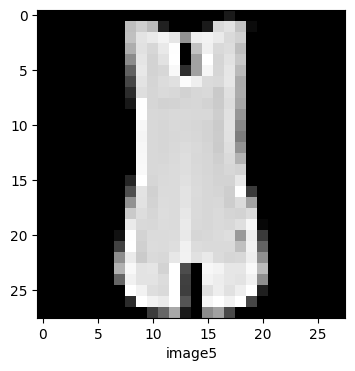

In [24]:
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
nb_images=0

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=1,
                                     shuffle=False):
    plt.figure(figsize=(4,4))
    plt.imshow(X_batch.reshape(28,28), cmap=plt.get_cmap("gray"))
    plt.xlabel('image'+str(nb_images+1))
    plt.show()
    nb_images+=1
    if nb_images >= 5:
      break

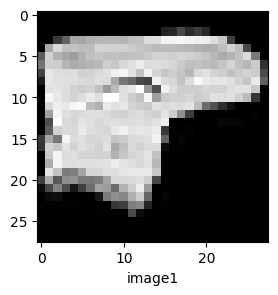

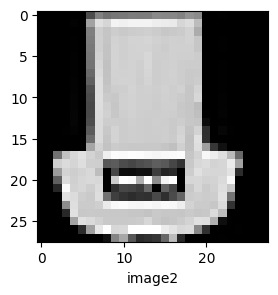

In [26]:
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
nb_images=0

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=1,
                                     shuffle=False,
                                     save_to_dir='./data',
                                     save_prefix='augmente',
                                     save_format='png'):
    plt.figure(figsize=(3,3))
    plt.imshow(X_batch.reshape(28,28), cmap=plt.get_cmap("gray"))
    plt.xlabel('image'+str(nb_images+1))
    plt.show()
    nb_images+=1
    if nb_images >= 2:
      break

In [38]:
# pour vérifier que l'image existe dans le répertoire
%cd ./data
%ls *.png
%cd ..

h:\deeplearning\deeplearning\TER\phaseI\data
 Le volume dans le lecteur H s'appelle SSD nvme
 Le num�ro de s�rie du volume est 2E21-4287

 R�pertoire de h:\deeplearning\deeplearning\TER\phaseI\data

05/02/2026  16:57               590 augmente_0_8773.png
05/02/2026  16:57               572 augmente_1_4239.png
               2 fichier(s)            1�162 octets
               0 R�p(s)  15�460�069�376 octets libres
h:\deeplearning\deeplearning\TER\phaseI


In [39]:
def train_cnn_model(model, train_generator, val_data, model_path,
                    epochs=10, patience=3):
    """
    Entraîne un modèle CNN avec un générateur de données et des callbacks.

    Args:
        model: Modèle CNN à entraîner.
        train_generator: Générateur d’images pour l'entraînement.
        val_data: Données de validation (X_test, y_test).
        model_path (str): Chemin de sauvegarde du modèle.
        epochs (int): Nombre d’époques d'entraînement.
        patience (int): Patience pour l'arrêt anticipé.

    Returns:
        Modèle entraîné avec les meilleurs poids restaurés.
    """
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=patience,
                      restore_best_weights=True, verbose=1),
        ModelCheckpoint(model_path, monitor='val_loss',
                        save_best_only=True, verbose=1)
    ]

    model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_data,
        callbacks=callbacks,
        verbose=1
    )

    return model

# Paramètres d'entraînement
epochs = 20
batch_size = 64
model_filename = "CNN_ImageGenerator_modelFMnist.keras"
model_path = os.path.join(model_dir, model_filename)

# Chargement et normalisation du jeu de données
X_train, y_train, X_test, y_test = load_dataset()
X_train, X_test = clean_data(X_train, X_test)

# Définition du modèle
model = define_model()
print(model.summary())

# Générateur de données avec transformations
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

# Entraînement du modèle
#model = train_cnn_model(model, train_generator,
#                          (X_test, y_test), model_path, epochs=epochs

Model: "Baseline_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_1 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2D_1 (MaxPooling2D)   │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 100)            │       540,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 542,230 (2.07 MB)

 Trainable params: 542,230 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

None


chargement et évaluation sur des données de test

In [54]:
model_filename = "CNN_ImageGenerator_modelFMnist.keras"
model_path = os.path.join(model_dir, model_filename)

# Chargement du modèle sauvegardé
model = load_model(model_path)

# Évaluation du modèle sur le jeu de test
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

# Affichage des résultats de test
print(f'Loss sur le jeu de test : {test_loss:.4f}')
print(f'Accuracy sur le jeu de test : {test_acc * 100:.2f}%')

# Prédiction sur le jeu de test
y_pred = model.predict(X_test)

# Calcul de la matrice de confusion
conf = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.tight_layout()
plt.show()

ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "Conv2D_1" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 28, 28, 3)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(None, 28, 28, 3), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

### Affichage des feature maps

On construit un modèle un poil plus gros, pour bien voir ce que font les features maps

In [1]:
def define_model(shapeinput=(28, 28, 1)):
    # Couche d'entrée
    inputs = Input(shape=shapeinput, name="Input_Layer")

    # Convolution + pooling (1)
    x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', name="Conv2D_1")(inputs)
    x = MaxPooling2D(pool_size=(2, 2), name="Maxpooling2D_1")(x)

    # Convolution + pooling (2)
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name="Conv2D_2")(x)
    x = MaxPooling2D(pool_size=(2, 2), name="Maxpooling2D_2")(x)

    # Convolution (3)
    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', name="Conv2D_3")(x)

    # Flatten + classification
    x = Flatten(name="flatten")(x)
    x = Dense(100, activation='relu', name="Dense_1")(x)
    outputs = Dense(10, activation='softmax', name="Output")(x)

    model = Model(inputs=inputs, outputs=outputs, name="CNN_for_FeatureMaps")

    # Compilation
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [6]:
def train_cnn_model(model, X_train, y_train, X_test, y_test,
                    model_path, epochs=10, batch_size=32, patience=3):
    """
    Entraîne un modèle CNN sur des images avec callbacks.

    Args:
        model: Modèle Keras compilé.
        X_train, y_train: Données d'entraînement.
        X_test, y_test: Données de validation.
        model_path (str): Chemin de sauvegarde du meilleur modèle.
        epochs (int): Nombre maximal d'époques.
        batch_size (int): Taille des mini-batchs.
        patience (int): Patience pour l'arrêt anticipé.

    Returns:
        Le modèle entraîné avec les meilleurs poids restaurés.
    """
    # Générateur sans transformation (modifiable si besoin)
    datagen = ImageDataGenerator()
    train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=patience,
                      restore_best_weights=True, verbose=1),
        ModelCheckpoint(filepath=model_path,
                        monitor='val_loss',
                        save_best_only=True,
                        verbose=1)
    ]

    model.fit(
        train_generator,
        validation_data=(X_test, y_test),
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    return model

In [25]:
# Paramètres
epochs = 10
batch_size = 32
model_filename = "CNN_forfeaturemaps_modelFMnist.keras"
model_path = os.path.join(model_dir, model_filename)

# Chargement et préparation des données
X_train, y_train, X_test, y_test = load_dataset()
X_train, X_test = clean_data(X_train, X_test)

# Définition du modèle
model = define_model()
print(model.summary())

# Générateur de données avec quelques transformations simples si souhaité
datagen = ImageDataGenerator()
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

model = train_cnn_model(model, X_train, y_train, X_test, y_test, model_path)

Model: "CNN_for_FeatureMaps"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_1 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Maxpooling2D_1 (MaxPooling2D)   │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_2 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Maxpooling2D_2 (MaxPooling2D)   │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_3 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,982 (816.34 KB)

 Trainable params: 208,982 (816.34 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6719 - loss: 0.8931
Epoch 1: val_loss improved from None to 0.42985, saving model to ./cnn_models/CNN_forfeaturemaps_modelFMnist.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7865 - loss: 0.5808 - val_accuracy: 0.8356 - val_loss: 0.4299
Epoch 2/10
1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8692 - loss: 0.3591
Epoch 2: val_loss improved from 0.42985 to 0.33200, saving model to ./cnn_models/CNN_forfeaturemaps_modelFMnist.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8741 - loss: 0.3426 - val_accuracy: 0.8767 - val_loss: 0.3320
Epoch 3/10
1859/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8882 - loss: 0.3024
Epoch 3: val_loss improved from 0.33200 to 0.30102, saving model to ./cnn_models/CNN_forfeaturemaps_modelFMnist.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8917 - loss: 0.2942 - val_accuracy: 0.8923 - val_loss: 0.3010
Epoch 4/10
1874/1875 ━━

In [34]:
# Chargement du modèle
model_filename = "CNN_forfeaturemaps_modelFMnist.keras"
model_path = os.path.join(model_dir, model_filename)
model_loaded = load_model(model_path)

# Affichage du nombre de couches
print("Le modèle contient", len(model_loaded.layers), "couches.\n")

# Création d'une entrée factice pour initialiser les dimensions
dummy_input = np.zeros((1, 28, 28, 1))
_ = model_loaded.predict(dummy_input)

# Affichage des noms des couches
print("Noms des couches :")
for name in model_loaded.layers:
    print("-", name.name)

# Affichage des dimensions de sortie de chaque couche
print("\nFormats des sorties des différentes couches :")
for i, layer in enumerate(model_loaded.layers):
    output_shape = layer.output.shape
    print(f"Layer [{i}] : {layer.name}, shape de sortie : {output_shape}")

Le modèle contient 9 couches.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Noms des couches :
- Input_Layer
- Conv2D_1
- Maxpooling2D_1
- Conv2D_2
- Maxpooling2D_2
- Conv2D_3
- flatten
- Dense_1
- Output

Formats des sorties des différentes couches :
Layer [0] : Input_Layer, shape de sortie : (None, 28, 28, 1)
Layer [1] : Conv2D_1, shape de sortie : (None, 26, 26, 32)
Layer [2] : Maxpooling2D_1, shape de sortie : (None, 13, 13, 32)
Layer [3] : Conv2D_2, shape de sortie : (None, 11, 11, 64)
Layer [4] : Maxpooling2D_2, shape de sortie : (None, 5, 5, 64)
Layer [5] : Conv2D_3, shape de sortie : (None, 3, 3, 128)
Layer [6] : flatten, shape de sortie : (None, 1152)
Layer [7] : Dense_1, shape de sortie : (None, 100)
Layer [8] : Output, shape de sortie : (None, 10)


On construit un modèle d'extraction

In [36]:
 # Création d’un modèle pour extraire les feature maps de la première couche de convolution
feature_map_layer1 = tf.keras.models.Model(
    inputs=model_loaded.input,                     # Entrée d'origine du modèle
    outputs=model_loaded.get_layer("Conv2D_1").output  # Sortie de la couche nommée "Conv2D_1"
)

On choisit une image qui va être utilisée par le modèle pour faire une prédiction

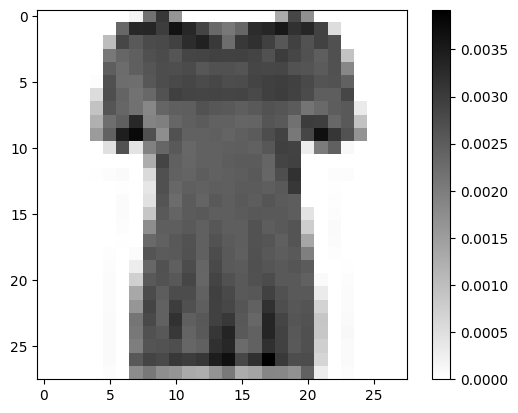

In [37]:
numimage = 10
plt.figure()
plt.imshow(train_images[numimage], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

# Sélection de l'image
my_image = train_images[numimage]

# Extension des dimensions pour manipuler une seule image
my_image = np.expand_dims(my_image, axis=0)

In [38]:
features=feature_map_layer1.predict(my_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


On affiche la dimension de sortie du modèle

In [39]:
print (features.shape)

(1, 26, 26, 32)


26x26x32 => 13x13x32
Et maintenant on affiche la sortie de cette couche.

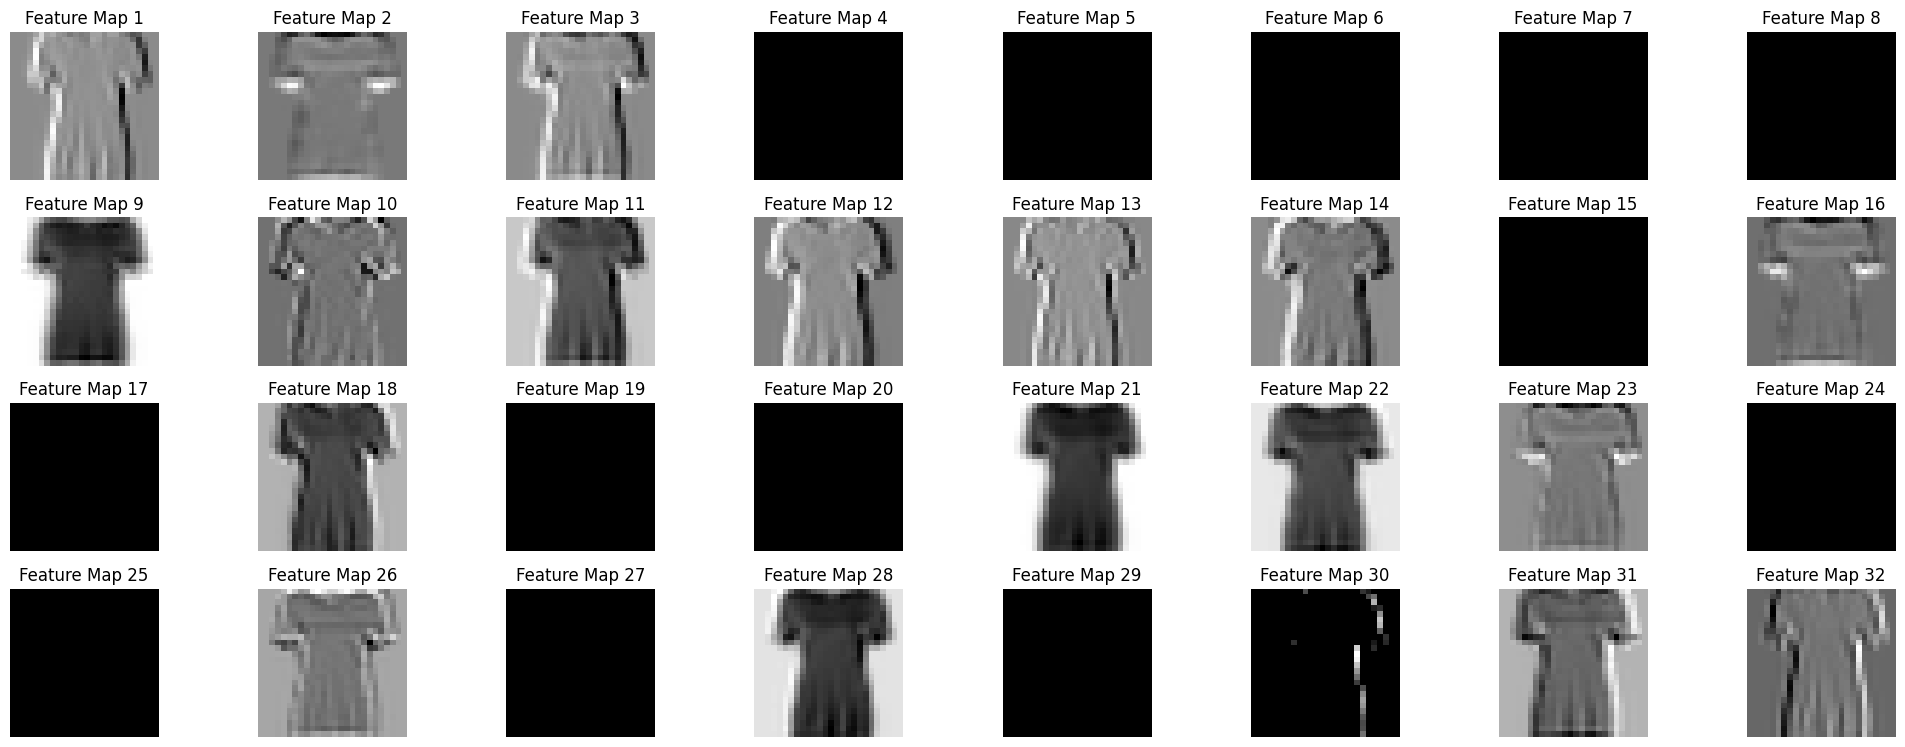

In [40]:
fig = plt.figure(figsize=(20, 15))

# Afficher chaque feature map
for i in range(1, features.shape[3] + 1):
    ax = plt.subplot(8, 8, i)
    ax.imshow(features[0, :, :, i - 1], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Feature Map {i}')

# Afficher toutes les feature maps
plt.tight_layout()
plt.show()

Certaines cases sont très proches, d'autres noires. Dropout? ou collision de filtres lors de la convergence?

Pour visualiser les sorties de couches intermédiaires, on construit un modèle à partir de ce qu'on veut (très pratique), ensuite, plus qu'à visualiser

In [41]:
 # Noms des couches de convolution à visualiser
list_layer_conv = ["Conv2D_1", "Conv2D_2", "Conv2D_3"]

# Récupération des sorties de ces couches
outputs = [model_loaded.get_layer(name).output for name in list_layer_conv]

# Création d’un modèle intermédiaire pour extraire les activations
feature_maps_model = tf.keras.models.Model(inputs=model_loaded.input, outputs=outputs)

# Prédiction des feature maps pour une image donnée (de forme (1, 28, 28, 1))
feature_maps = feature_maps_model.predict(my_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


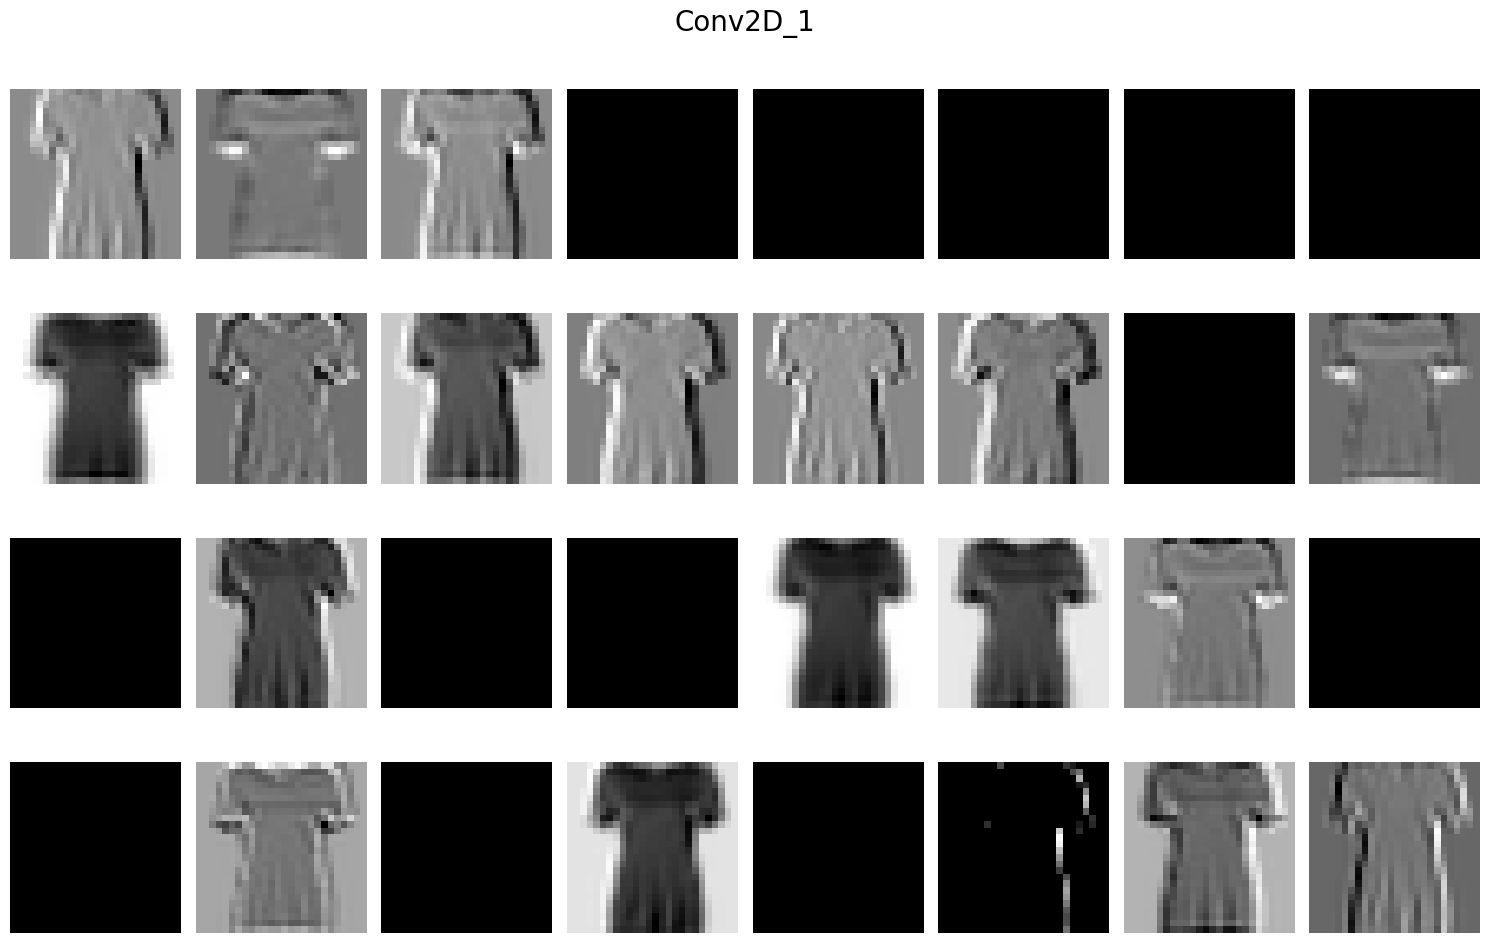

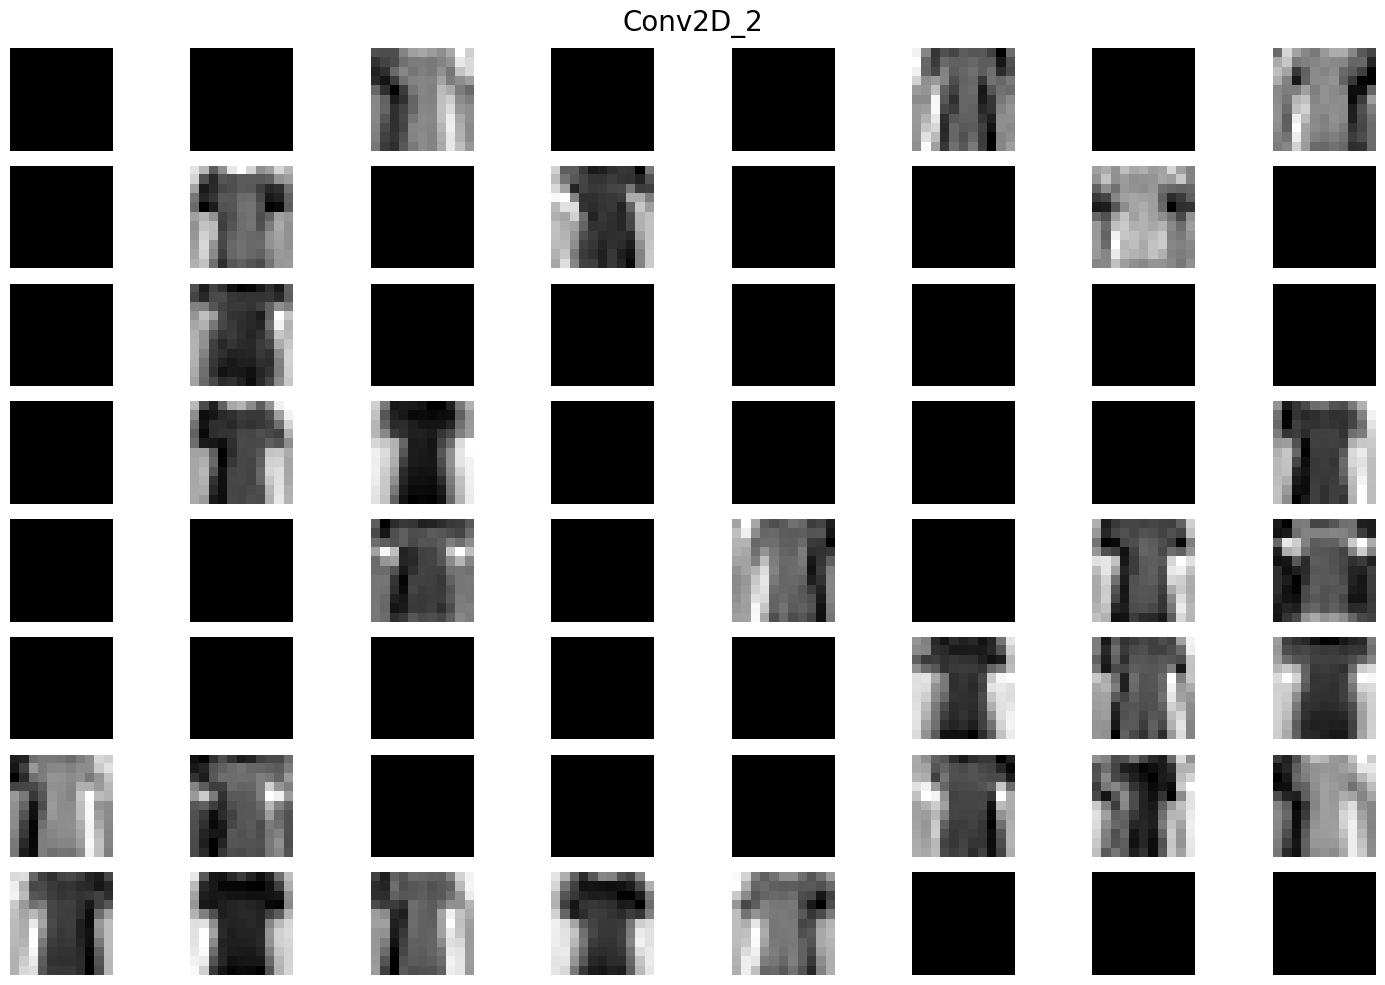

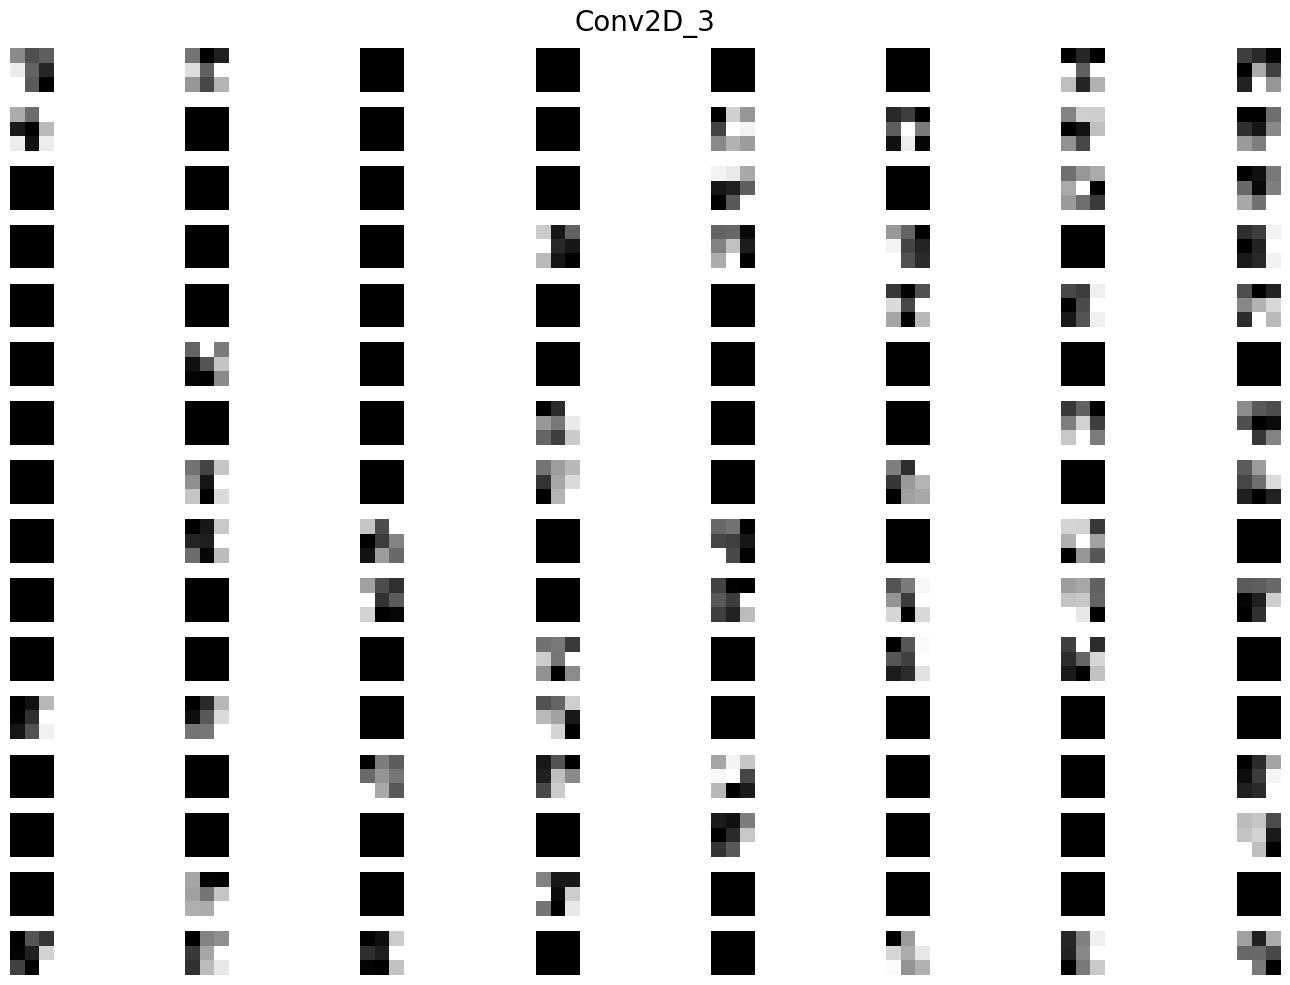

In [42]:
# Affichage des feature maps pour chaque couche de convolution sélectionnée
for layer_name, fmap in zip(list_layer_conv, feature_maps):
    # Création d'une figure pour la couche en cours
    fig = plt.figure(figsize=(15, 10))
    fig.suptitle(layer_name, fontsize=20)

    num_feature_maps = fmap.shape[-1]  # Nombre de cartes d’activation
    cols = 8  # Nombre de colonnes
    rows = (num_feature_maps // cols) + (num_feature_maps % cols > 0)

    for j in range(num_feature_maps):
        plt.subplot(rows, cols, j + 1)
        plt.imshow(fmap[0, :, :, j], cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## Transfer learning

Pour fine-tune, ou extraire carement des couches.

Ici, on bidouille ResNet50

In [43]:
model_resnet50=ResNet50()
model_resnet50.summary()

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

EUUUUHHHH L'EST GROS?

Donc en gros, ce qu'on va faire, c'est tirer parti de ce modèle pré-entrainé, en gelant les poids, et en modifiant que la prédiction, avec quelques MLP à la fin.

On va tester ça sur fashion mnist. Ceci dit, on va changer les dimensions pour que tout soit compatible.

In [66]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

On reduit le dataset, car on cherche pas encore à faire de bon classifieur mais juste à observer comment ça marche.

In [67]:
# Prendre les 1000 premières images et leurs étiquettes
X_train = X_train[:1000]  # Prendre les 1000 premières images
y_train = y_train[:1000]   # Prendre les 1000 premières étiquettes

On redimensionne !

In [68]:
# Redimensionner les images à 28x28 et ajouter une dimension de canaux (1 pour grayscale)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

# Normaliser les images entre 0 et 1
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# Conversion en 3 canaux (grayscale à RGB)
X_train = np.concatenate([X_train, X_train, X_train], axis=-1)  # Convertir en 3 canaux
X_test = np.concatenate([X_test, X_test, X_test], axis=-1)      # Convertir en 3 canaux

# One-hot encoding des labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print ("X_train et X_test en image 28x28 et 3 canaux : ", X_train.shape, ' ', X_test.shape)

X_train et X_test en image 28x28 et 3 canaux :  (1000, 28, 28, 3)   (10000, 28, 28, 3)


Si on veut le faire à la volée, on peut mettre une couche lambda dans le modèle (c'est mieux!)

In [69]:
# Dimensions d'entrée
input_shape_mnist = (28, 28, 3)
input_shape_resnet = (224, 224, 3)

# Fonction sérialisable pour le redimensionnement
@tf.keras.utils.register_keras_serializable()
def resize_to_resnet(image):
    return tf.image.resize(image, input_shape_resnet[:2])

# Définir l'entrée
inputs = Input(shape=input_shape_mnist, name="Input_Layer")

# Redimensionnement des images
x = Lambda(resize_to_resnet, name="Lambda_Layer")(inputs)

# Importation de ResNet50 sans la couche finale
base_model = ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    name="ResNet_Layer"
)
base_model.trainable = False  # Geler les poids

# Application de ResNet50
x = base_model(x)

# Partie classification personnalisée
x = Dense(512, activation='relu', name="Dense1_Layer")(x)
outputs = Dense(10, activation='softmax', name="Output_Layer")(x)

# Construction du modèle
model = Model(inputs=inputs, outputs=outputs)

# Compilation
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Résumé
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Lambda_Layer (Lambda)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ResNet_Layer (Functional)       │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense1_Layer (Dense)            │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,641,930 (94.00 MB)

 Trainable params: 1,054,218 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Les couches d'entrainement du modèle:

In [70]:
# Afficher les couches entraînables du modèle
print("Couches entraînables dans le modèle :")
for layer in model.layers:
    if layer.trainable:
        print(f"{layer.name} ({layer.__class__.__name__})")

Couches entraînables dans le modèle :
Input_Layer (InputLayer)
Lambda_Layer (Lambda)
Dense1_Layer (Dense)
Output_Layer (Dense)


In [71]:
# Division du jeu d'entraînement en sous-ensembles entraînement et validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Générateur simple de données à partir de tableaux NumPy en mémoire
def simple_data_generator(X, y, batch_size):
    """
    Génère des lots de données (X, y) de taille batch_size.
    Fonctionne en boucle infinie pour être compatible avec model.fit().
    """
    num_samples = len(X)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_x = X[offset:offset + batch_size]
            batch_y = y[offset:offset + batch_size]
            yield batch_x, batch_y

In [50]:
def train_transfer_model(model,
                         train_generator,
                         val_generator,
                         steps_per_epoch,
                         validation_steps,
                         model_path,
                         epochs=40,
                         patience=5):
    """
    Entraîne un modèle avec transfer learning à partir de générateurs.

    Args:
        model: Modèle Keras compilé.
        train_generator: Générateur d'entraînement.
        val_generator: Générateur de validation.
        steps_per_epoch (int): Nombre de lots par époque.
        validation_steps (int): Nombre de lots pour la validation.
        model_path (str): Chemin de sauvegarde du meilleur modèle.
        epochs (int): Nombre d'époques.
        patience (int): Patience pour l'arrêt anticipé.

    Returns:
        Le modèle entraîné avec les meilleurs poids restaurés.
    """
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=patience,
                      restore_best_weights=True, verbose=1),
        ModelCheckpoint(filepath=model_path, monitor='val_loss',
                        save_best_only=True, verbose=1)
    ]

    model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_generator,
        validation_steps=validation_steps,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    return model


In [72]:
# Paramètres
epochs = 40
batch_size = 32
model_filename_transfer = "CNN_transferlearning_modelFMnist.keras"
model_path = os.path.join(model_dir, model_filename_transfer)

# Générateurs
train_generator = simple_data_generator(X_train_split, y_train_split,
                                        batch_size)
val_generator = simple_data_generator(X_val_split, y_val_split, batch_size)

# Calcul des steps
steps_per_epoch = int(np.ceil(len(X_train_split) / batch_size))
validation_steps = int(np.ceil(len(X_val_split) / batch_size))



In [73]:
# Entraînement
model = train_transfer_model(
   model,
   train_generator,
   val_generator,
   steps_per_epoch,
   validation_steps,
   model_path,
   epochs=epochs,
   patience=5
)

Epoch 1/40


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.1098 - loss: 2.5019
Epoch 1: val_loss improved from None to 2.16769, saving model to ./cnn_models/CNN_transferlearning_modelFMnist.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 438ms/step - accuracy: 0.1475 - loss: 2.3802 - val_accuracy: 0.1200 - val_loss: 2.1677
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.1965 - loss: 2.1233
Epoch 2: val_loss improved from 2.16769 to 1.97369, saving model to ./cnn_models/CNN_transferlearning_modelFMnist.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 406ms/step - accuracy: 0.2587 - loss: 2.0598 - val_accuracy: 0.2545 - val_loss: 1.9737
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.3160 - loss: 1.9516
Epoch 3: val_loss improved from 1.97369 to 1.84412, saving model to ./cnn_models/CNN_transferlearning_modelFMnist.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 414ms/step - accuracy: 0.3438 - loss: 1.9075 - val_accuracy: 0.4241 - val_loss: 1.8441
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3

KeyboardInterrupt: 

In [74]:
# Chargement du modèle sauvegardé
model_filename = "CNN_transferlearning_modelFMnist.keras"
model_path = os.path.join(model_dir, model_filename)
model = load_model(model_path)

# Prédiction
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Conversion de y_test
y_true_labels = np.argmax(y_test, axis=1)

# Matrice de confusion
conf = confusion_matrix(y_true_labels, y_pred_labels)




313/313 ━━━━━━━━━━━━━━━━━━━━ 96s 304ms/step


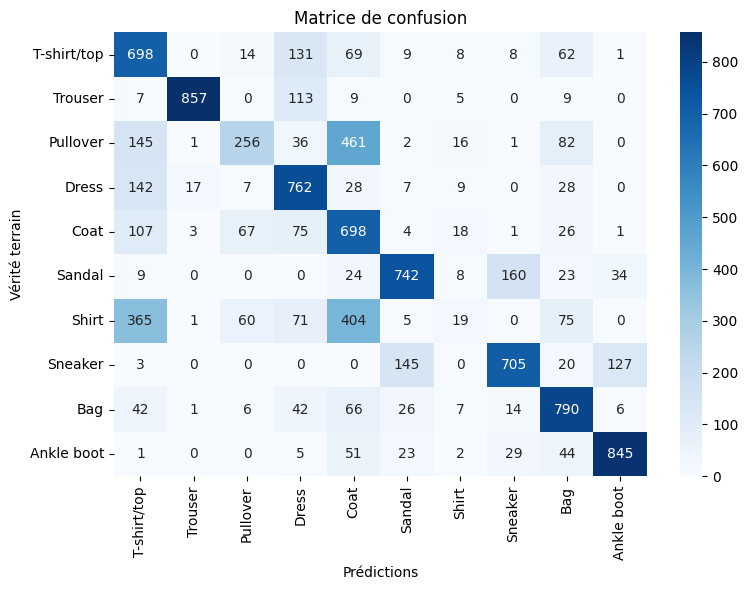

In [75]:
# Affichage
plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vérité terrain")
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


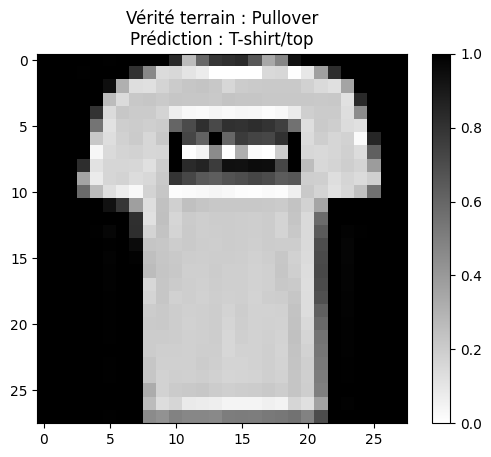

In [81]:
numimage = 1
# Prédiction
y_pred = model.predict(X_train[numimage:numimage+1])  # Prédire pour une seule image
y_pred_labels = np.argmax(y_pred, axis=1)

# Conversion de y_test
y_true_labels = np.argmax(y_test, axis=1)


plt.figure()
plt.imshow(X_train[numimage], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.title(f"Vérité terrain : {class_names[y_true_labels[numimage]]}\nPrédiction : {class_names[y_pred_labels[0]]}")
plt.show()

# Sélection de l'image
my_image = X_train[numimage]

# Extension des dimensions pour manipuler une seule image
my_image = np.expand_dims(my_image, axis=0)


# bidouillage

In [ ]:
# Chargement du modèle sauvegardé
model_filename = "CNN_transferlearning_modelFMnist.keras"
model_path = os.path.join(model_dir, model_filename)
model = load_model(model_path)


## tester le modèle

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


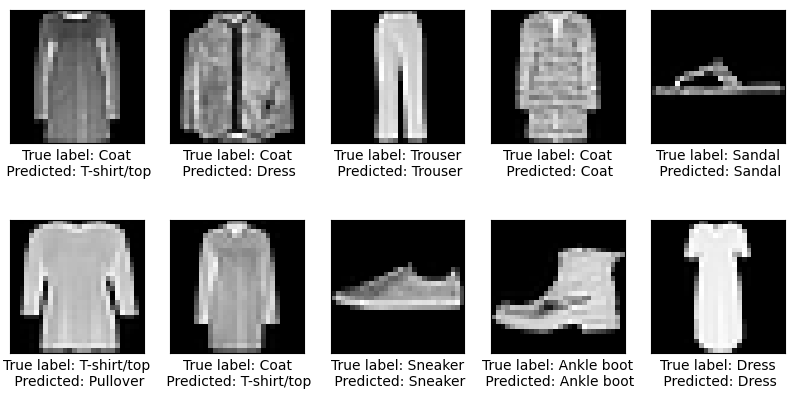

In [118]:


numimage = 150
# Prédiction
y_pred = model.predict(X_test[numimage:numimage+10])  # Prédire 10 image
y_pred_labels = np.argmax(y_pred, axis=1)

# Conversion de y_test
y_true_labels = np.argmax(y_test, axis=1)

plt.figure(figsize=(10,5))
columns = 10
for i in range(columns):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i+numimage],cmap=plt.cm.binary)
    plt.xlabel("True label: " + class_names[y_true_labels[i+numimage]] + "\n Predicted: " + class_names[y_pred_labels[i]])